<a href="https://colab.research.google.com/github/beatricekiplagat/Deepfake-Audio-Recognition/blob/dev_branch/DEEPFAKE_AUDIO_DETECTION_TRANSFER_LEARNING_MODELS_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet 50

## Importing Libraries

In [ ]:
!pip install wandb

In [30]:
# import necessary libraries
import wandb
from wandb.keras import WandbCallback
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [3]:
#Mount google drive to access data

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Initialize WandB

In [4]:
# Initialize wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
wandb.init(project='DeepFake Audio Detection', entity='ruoro',
           config = {
               'learning_rate': 0.004,
               'epochs': 5,
               'batch_size' : 4,
               'loss_function' : 'binary_crossentropy'
           })

wandb: Currently logged in as: ruoro (use `wandb login --relogin` to force relogin)


## Loading Data and Modelling

In [21]:
# define train and test data paths
train_path ='/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train'
test_path = '/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test'

In [22]:
# resize all the images
IMAGE_SIZE = [224, 224]
# add preprocessing layer to the front of ResNet
# the include_top false statement will allow us to be able to set the number of classes on the top layer that we will create
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train - resnet has existing weights
for layer in resnet.layers:
  layer.trainable = False
  
 
  # useful for getting number of classes
  # this will count the number of classes we have in our dataset assuming that the data is grouped into specific folders
folders = glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train/*')

In [11]:
# our layers
x = Flatten()(resnet.output)
x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='sigmoid')(x)


In [12]:
# create a model object
model = Model(inputs=resnet.input, outputs=prediction)
# view the structure of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [15]:
# tell the model what cost and optimization method to use
from tensorflow.keras.optimizers import Adam
opt = Adam (learning_rate= 0.001)
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 4,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 4,
                                            class_mode = 'categorical')

# '''r=model.fit_generator(training_set,
#                          samples_per_epoch = 8000,
#                          nb_epoch = 5,
#                          validation_data = test_set,
#                          nb_val_samples = 2000)'''

Found 1650 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [34]:
# Adding Early Stopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
estp = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode="max", patience= 10)
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

In [36]:
# fit the model
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=30, #len(training_set),
  validation_steps=20, #len(test_set)
  callbacks=[WandbCallback(), estp, mcp_save, reduce_lr_loss]
)

Epoch 1/10
30/30 [==============================] - 64s 2s/step - loss: 1.9957 - accuracy: 0.4667 - val_loss: 1.9376 - val_accuracy: 0.5500
Epoch 2/10
30/30 [==============================] - 57s 2s/step - loss: 2.2304 - accuracy: 0.5000 - val_loss: 4.4223 - val_accuracy: 0.4625
Epoch 3/10
30/30 [==============================] - 56s 2s/step - loss: 1.6420 - accuracy: 0.5333 - val_loss: 1.2090 - val_accuracy: 0.5125


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/10
30/30 [==============================] - 56s 2s/step - loss: 1.1829 - accuracy: 0.4667 - val_loss: 0.7661 - val_accuracy: 0.5125
Epoch 5/10
30/30 [==============================] - 59s 2s/step - loss: 1.5235 - accuracy: 0.5250 - val_loss: 1.1100 - val_accuracy: 0.4500
Epoch 6/10
30/30 [==============================] - 55s 2s/step - loss: 1.0561 - accuracy: 0.5333 - val_loss: 0.7862 - val_accuracy: 0.5500
Epoch 7/10
30/30 [==============================] - 55s 2s/step - loss: 0.8071 - accuracy: 0.5333 - val_loss: 0.8405 - val_accuracy: 0.4500
Epoch 8/10
30/30 [==============================] - 55s 2s/step - loss: 0.8444 - accuracy: 0.5833 - val_loss: 1.0062 - val_accuracy: 0.4375
Epoch 9/10
30/30 [==============================] - 54s 2s/step - loss: 1.0094 - accuracy: 0.5500 - val_loss: 0.9448 - val_accuracy: 0.4625
Epoch 10/10
30/30 [==============================] - 55s 2s/step - loss: 0.9921 - accuracy: 0.5750 - val_loss: 0.7389 - val_accuracy: 0.5500


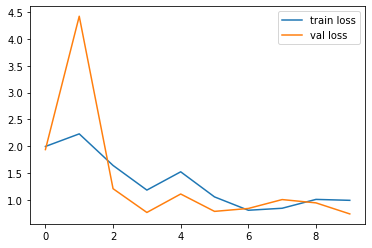

<Figure size 432x288 with 0 Axes>

In [37]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')




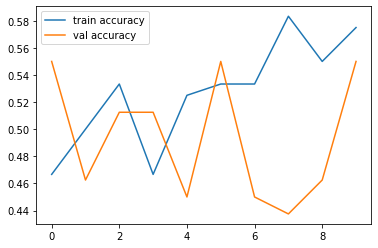

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


<Figure size 432x288 with 0 Axes>

In [38]:
# accuracies
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

import tensorflow as tf

from keras.models import load_model

model.save('DeepfakeAudioDetectionResnet.h5')